In [1]:
import pandas as pd
import os
import numpy as np
import epiweeks
import datetime
import requests
import zipfile
import csv
from contextlib import ExitStack
import progressbar as pbar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
today = datetime.date.today().strftime("%d-%m-%Y")
data_dir_path = f'data/World/{today}'
result_dir_path = f'result/World/{today}'
countries = os.listdir(data_dir_path)
if not os.path.exists(f'{result_dir_path}'):
    os.mkdir(f'{result_dir_path}')
country = 'Afghanistan'
if not os.path.exists(f'{result_dir_path}/{country}'):
    os.mkdir(f'{result_dir_path}/{country}')

In [3]:
def load_cases(country, sex='b'):
    translation_age = {0: '00-04', 5: '05-09',
                       10: '10-14', 15: '15-19',
                       20: '20-24', 25: '25-29',
                       30: '30-34', 35: '35-39',
                       40: '40-04', 45: '45-49',
                       50: '50-04', 55: '55-59',
                       60: '60-04', 65: '65-69',
                       70: '70-04', 75: '75-79',
                       80: '80-04', 85: '85-89',
                       90: '90-04', 95: '95-99',
                       100: '100-104'}
    cases = pd.read_csv(f'{data_dir_path}/{country}/cases_5.csv', encoding='latin1')
    cases['Date'] =pd.to_datetime(cases.Date)
    cases = cases.sort_values(by=['Date', 'Region'])
    cases = cases.drop('Code', axis='columns')
    cases['Region'].replace({'All': country}, inplace=True)
    cases = cases[cases['Sex'] == sex]
    cases = cases.drop(['Country', 'AgeInt', 'Sex'], axis='columns')
    cases['Age'].replace(translation_age, inplace=True)
    cases.rename(columns={'Age': 'Age group', 'Region': 'location_name', 'Date': 'date', 'Cases': 'value'}, inplace=True)
    cases = cases.reindex(['date', 'location_name', 'Age group', 'value'], axis=1)
    return cases

In [4]:
def load_deaths(country, sex='b'):
    translation_age = {0: '00-04', 5: '05-09',
                       10: '10-14', 15: '15-19',
                       20: '20-24', 25: '25-29',
                       30: '30-34', 35: '35-39',
                       40: '40-04', 45: '45-49',
                       50: '50-04', 55: '55-59',
                       60: '60-04', 65: '65-69',
                       70: '70-04', 75: '75-79',
                       80: '80-04', 85: '85-89',
                       90: '90-04', 95: '95-99',
                       100: '100-104'}
    deaths = pd.read_csv(f'{data_dir_path}/{country}/deaths_5.csv', encoding='latin1')
    deaths['Date'] =pd.to_datetime(deaths.Date)
    deaths = deaths.sort_values(by=['Date', 'Region'])
    deaths = deaths.drop('Code', axis='columns')
    deaths['Region'].replace({'All': country}, inplace=True)
    deaths = deaths[deaths['Sex'] == sex]
    deaths = deaths.drop(['Country', 'AgeInt', 'Sex'], axis='columns')
    deaths['Age'].replace(translation_age, inplace=True)
    deaths.rename(columns={'Age': 'Age group', 'Region': 'location_name', 'Date': 'date', 'Deaths': 'value'}, inplace=True)
    deaths = deaths.reindex(['date', 'location_name', 'Age group', 'value'], axis=1)
    return deaths

In [5]:

cases = load_cases(country)
cases

,date,location_name,Age group,value
0,2020-01-07,Afghanistan,00-04,43.4
1,2020-01-07,Afghanistan,05-09,125.6
2,2020-01-07,Afghanistan,10-14,371.6
3,2020-01-07,Afghanistan,15-19,1153.4
4,2020-01-07,Afghanistan,20-24,3151.6
...,...,...,...,...
10012,2021-12-15,Afghanistan,80-04,1393.8
10013,2021-12-15,Afghanistan,85-89,716.4
10014,2021-12-15,Afghanistan,90-04,273.0
10015,2021-12-15,Afghanistan,95-99,65.2


In [6]:
deaths = load_deaths(country)
deaths.head(25)

,date,location_name,Age group,value
0,2020-01-07,Afghanistan,00-04,0.0
1,2020-01-07,Afghanistan,05-09,0.0
2,2020-01-07,Afghanistan,10-14,1.5
3,2020-01-07,Afghanistan,15-19,3.5
4,2020-01-07,Afghanistan,20-24,6.3
5,2020-01-07,Afghanistan,25-29,11.7
6,2020-01-07,Afghanistan,30-34,20.3
7,2020-01-07,Afghanistan,35-39,33.7
8,2020-01-07,Afghanistan,40-04,51.4
9,2020-01-07,Afghanistan,45-49,65.6


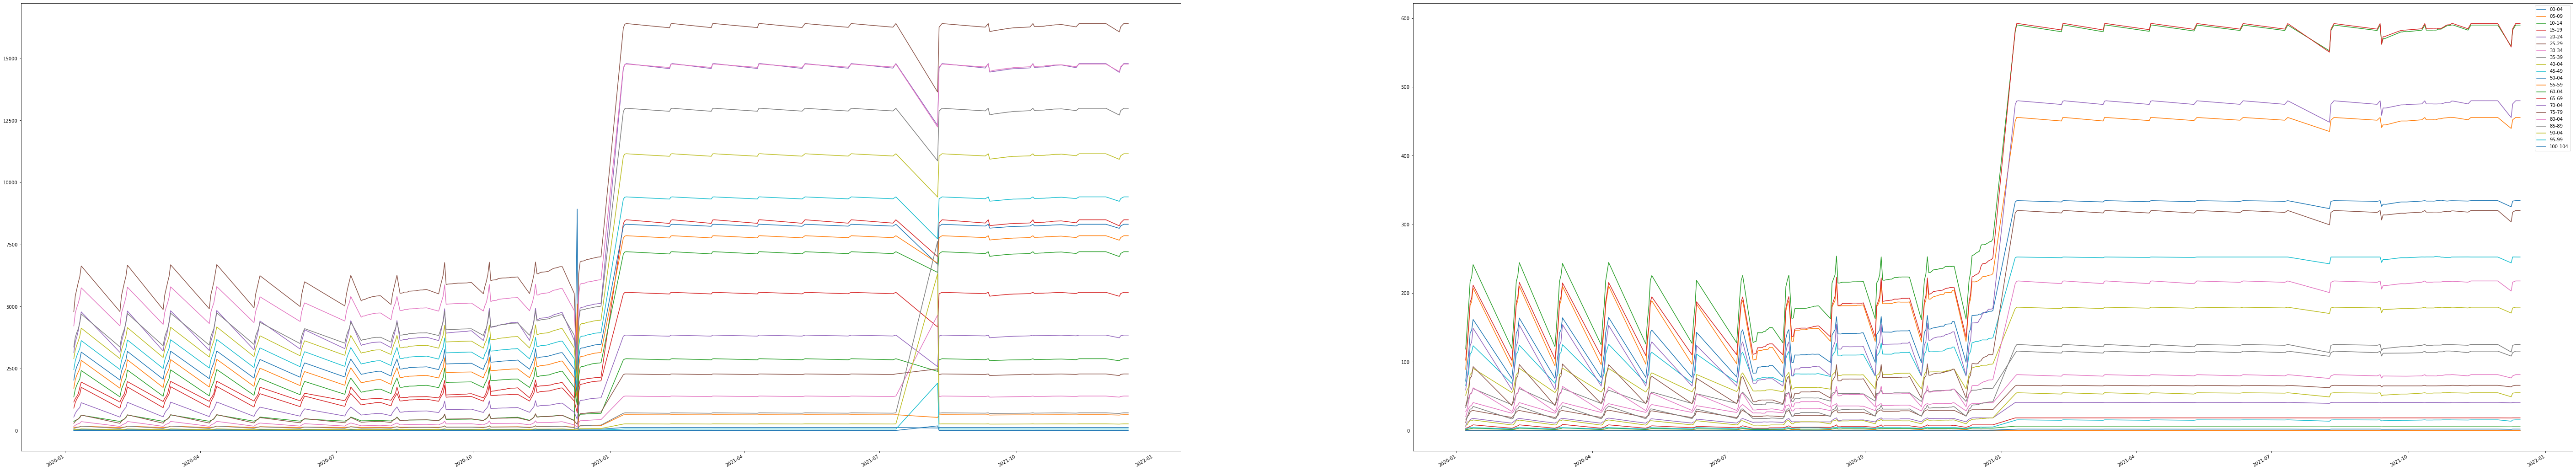

In [7]:
region = 'Afghanistan'

fig, axes = plt.subplots(1, 2, figsize=(100, 20))
for age_group in cases['Age group'].unique():
    regional_cases = cases[np.logical_and(cases['Age group'] == age_group, cases['location_name'] == region)]
    axes[0].plot(regional_cases['date'],
                 regional_cases['value'],
                 label=age_group)
    regional_deaths = deaths[np.logical_and(deaths['Age group'] == age_group, deaths['location_name'] == region)]
    axes[1].plot(regional_deaths['date'],
                 regional_deaths['value'],
                 label=age_group)    
    
plt.legend()
fig.autofmt_xdate()
plt.savefig(f'{result_dir_path}/{country}/{region}/deaths.png')

In [20]:
def prepare_weekly_covid_deaths(region):
    daily_regional_deaths = deaths[deaths['location_name'] == region].reset_index(drop=True)
    daily_regional_deaths = daily_regional_deaths.pivot(values='value', columns='date', index='Age group').fillna(0)
    daily_regional_deaths[daily_regional_deaths < 0] = 0

    weekly_regional_deaths = daily_regional_deaths.copy()
    [str(c) for c in daily_regional_deaths.columns]
    weekly_regional_deaths.columns = [epiweeks.Week.fromdate(datetime.date(year=int(str(c)[:4]), month=int(str(c)[5:7]), day=int(str(c)[8:10]))).isoformat() for c in daily_regional_deaths.columns]           
    t = weekly_regional_deaths.transpose()
    weekly_regional_deaths = t.groupby(t.index).sum().transpose()
    return daily_regional_deaths, weekly_regional_deaths